# Fit Convergent Cross Mapping Model to Data Sets

In [2]:
import pandas as pd
import numpy as np
import skccm as ccm
import matplotlib.pyplot as plt
import seaborn as sns
from skccm.utilities import train_test_split
from teaspoon.parameter_selection.FNN_n import FNN_n

np.seterr(divide='ignore', invalid='ignore')

{'divide': 'ignore', 'over': 'warn', 'under': 'ignore', 'invalid': 'ignore'}

In [3]:
# from 2012-2020 9 years in total, 12 months for each year
merged_data = pd.read_csv('merged_data.csv',index_col=0)
merged_data = merged_data.sort_values(by=['year','month'],ascending=[True, True])

In [4]:
merged_data.head()

,USstate,year,month,nTweets_x,nTweets_y,Number of establishments (ESTAB),abbr,full,population,actual_rape_total
0,al,2012,1,51744.000000,3.00,367.000000,al,Alabama,4834334,106
108,ak,2012,1,20125.600000,1.35,375.962006,ak,Alaska,735190,39
216,az,2012,1,57016.090909,1.00,99.781590,az,Arizona,6572455,205
324,ar,2012,1,7733.000000,1.00,212.571483,ar,Arkansas,2981157,108
432,ca,2012,1,134228.000000,5.00,547.446496,ca,California,38183375,671


# Alcohol vs Crime

## Part A: State-wise

In [5]:
state_list = list(set(merged_data['USstate'].to_list()))
print(state_list)

['al', 'ak', 'mn', 'tn', 'mi', 'nv', 'nh', 'ne', 'nm', 'ri', 'or', 'la', 'co', 'ga', 'il', 'md', 'ok', 'sd', 'az', 'vt', 'ms', 'ca', 'hi', 'ia', 'me', 'pa', 'dc', 'ma', 'mt', 'nd', 'ut', 'ct', 'mo', 'de', 'sc', 'in', 'ar', 'nj', 'ky', 'ks', 'nc', 'oh', 'tx', 'id', 'fl', 'ny', 'va']


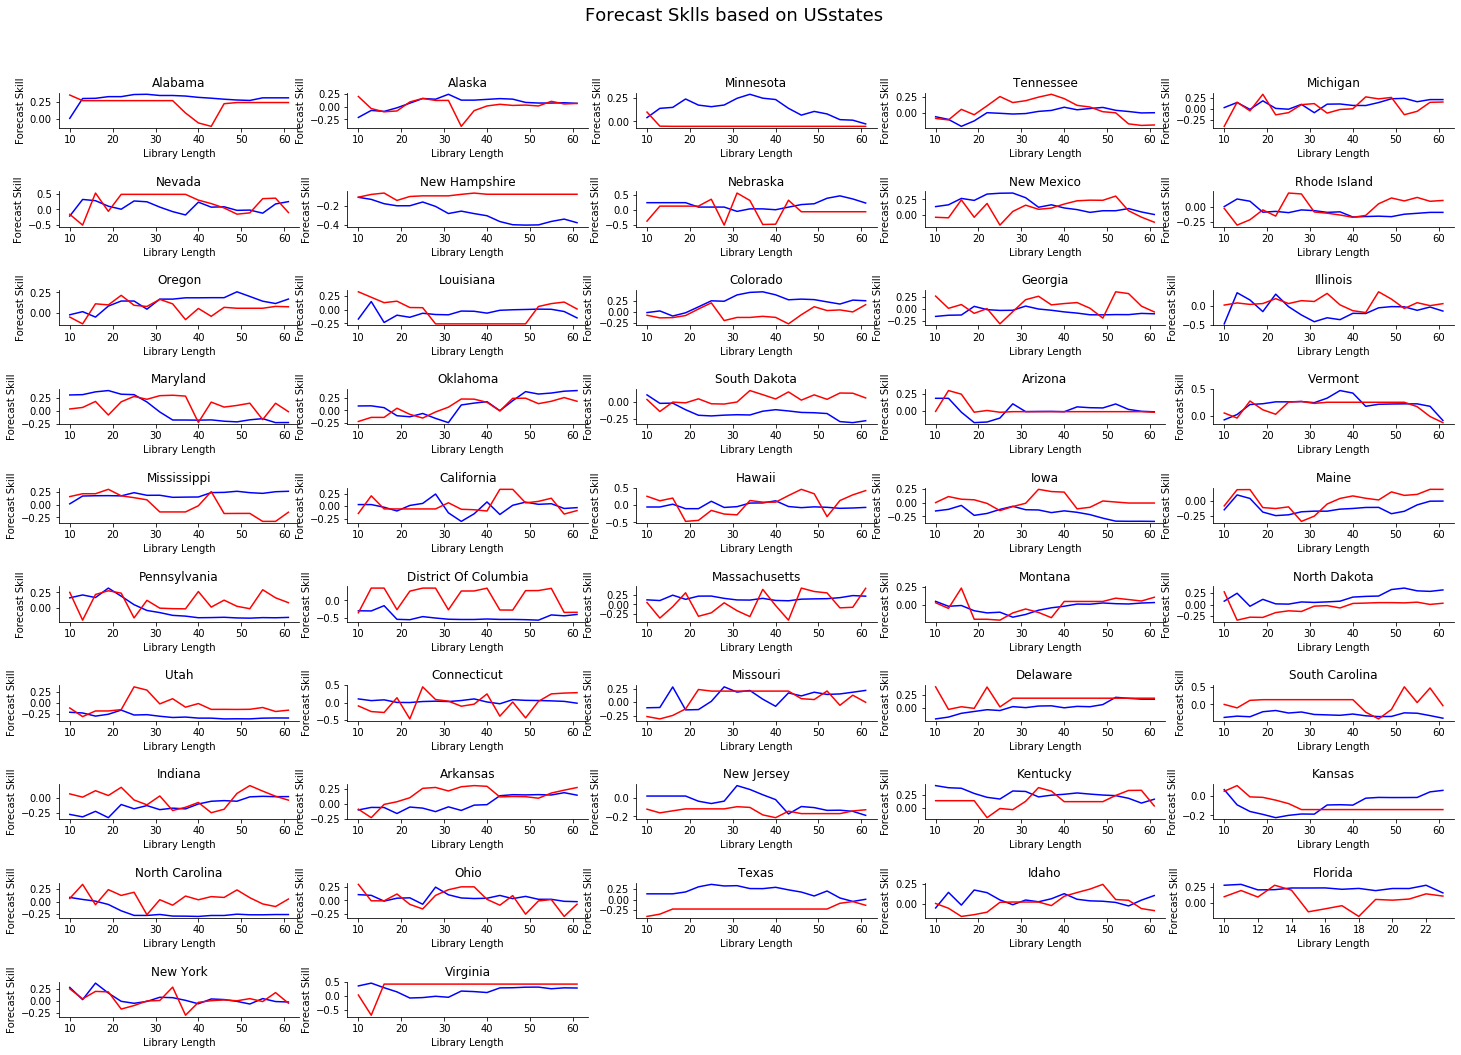

In [7]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

plt.figure(figsize=(25, 17))
plt.subplots_adjust(hspace=1.8)
plt.suptitle("Forecast Sklls based on USstates", fontsize=18, y=0.95)

for i in range(len(state_list)):
    
    data = merged_data[merged_data['USstate']==state_list[i]]
    curr_state = data['full'].iloc[0]
    data = data.groupby(['year','month']).sum()
    data['misogyny_proportion'] = data['nTweets_y'] / data['nTweets_x']
    data['crime_proportion'] = data['actual_rape_total'] / data['population']
    
    # 0. extract data
    x1_alcohol = data['Number of establishments (ESTAB)'].to_numpy()
    x2_crime = data['crime_proportion'].to_numpy()
    
    # 1. Calculate Mutual information
    e1 = ccm.Embed(x1_alcohol)
    e2 = ccm.Embed(x2_crime)

    mi1 = e1.mutual_information(10)
    mi2 = e2.mutual_information(10)
               
    min_index1 = min(range(len(mi1)), key=mi1.__getitem__)
    min_index2 = min(range(len(mi2)), key=mi2.__getitem__)
    min_index1 = max(min_index1, 1)
    min_index2 = max(min_index2, 1)
    lag = max(min_index1, min_index2)
    
    # 2. Embed the time series
    perc_FNN, embed = FNN_n(x2_crime, lag, plotting = False)
    X1 = e1.embed_vectors_1d(lag,embed)
    X2 = e2.embed_vectors_1d(lag,embed)
    
    # 3. Forecast skill as a function of library length
    # split the embedded time series
    x1tr, x1te, x2tr, x2te = train_test_split(X1,X2, percent=.75)

    CCM = ccm.CCM() # initiate the class

    # library lengths to test
    len_tr = len(x1tr)
    lib_lens = np.arange(10, len_tr, len_tr/20, dtype='int')
    
    # test causation
    CCM.fit(x1tr,x2tr)
    x1p, x2p = CCM.predict(x1te, x2te,lib_lengths=lib_lens)
    
    sc1,sc2 = CCM.score()
    # plot
    ax = plt.subplot(10, 5, i+1)
    ax.plot(lib_lens,sc1,label='X1 xmap X2', color='blue') # alcohol predict crime
    ax.plot(lib_lens,sc2, label='X2 xmap X1', color='red') # crime predict alcohol
    ax.set_xlabel('Library Length')
    ax.set_ylabel('Forecast Skill')
    ax.set_title(curr_state)
    sns.despine()

# Misogyny Tweet vs Crime

## Part A: State-wise

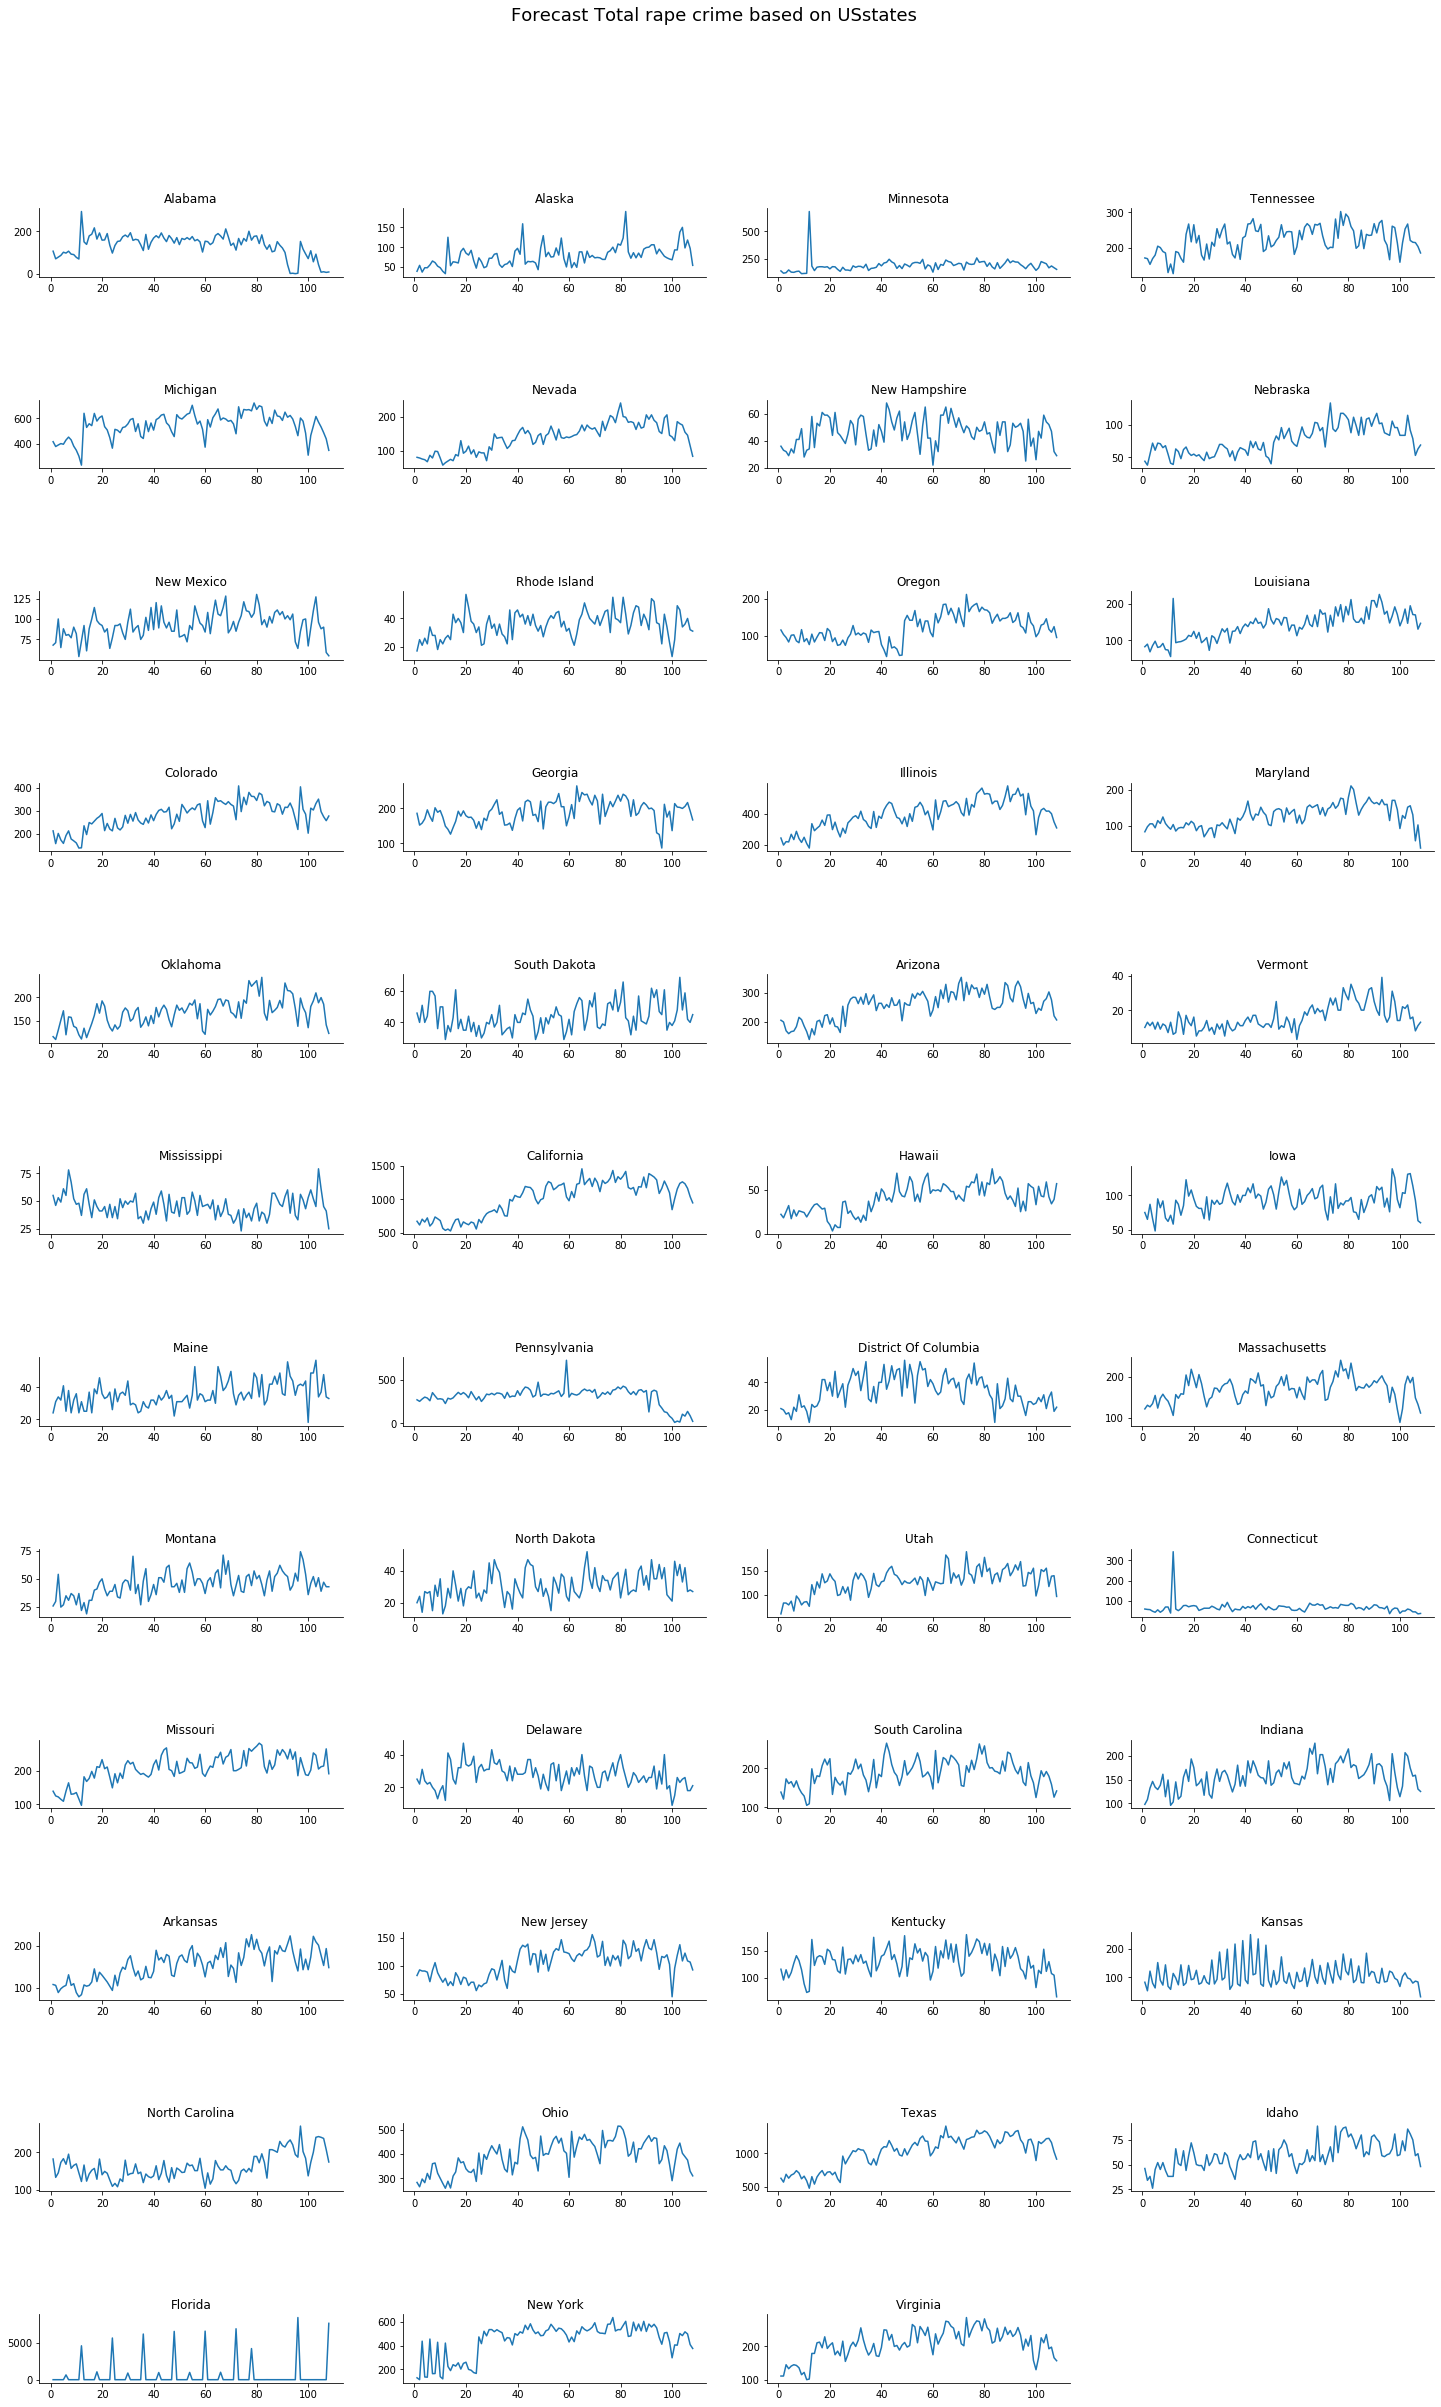

In [8]:
plt.figure(figsize=(25, 40))
plt.subplots_adjust(hspace=1.8)
plt.suptitle("Forecast Total rape crime based on USstates", fontsize=18, y=0.95)

for i in range(len(state_list)):
    
    data = merged_data[merged_data['USstate']==state_list[i]]
    curr_state = data['full'].iloc[0]
    data = data.groupby(['year','month']).sum()

    x1_rape_total = data['actual_rape_total'].to_numpy()

    # plot
    ax = plt.subplot(12, 4, i+1)
    ax.plot(np.arange(1,109),x1_rape_total)
    ax.set_title(curr_state)
    sns.despine()

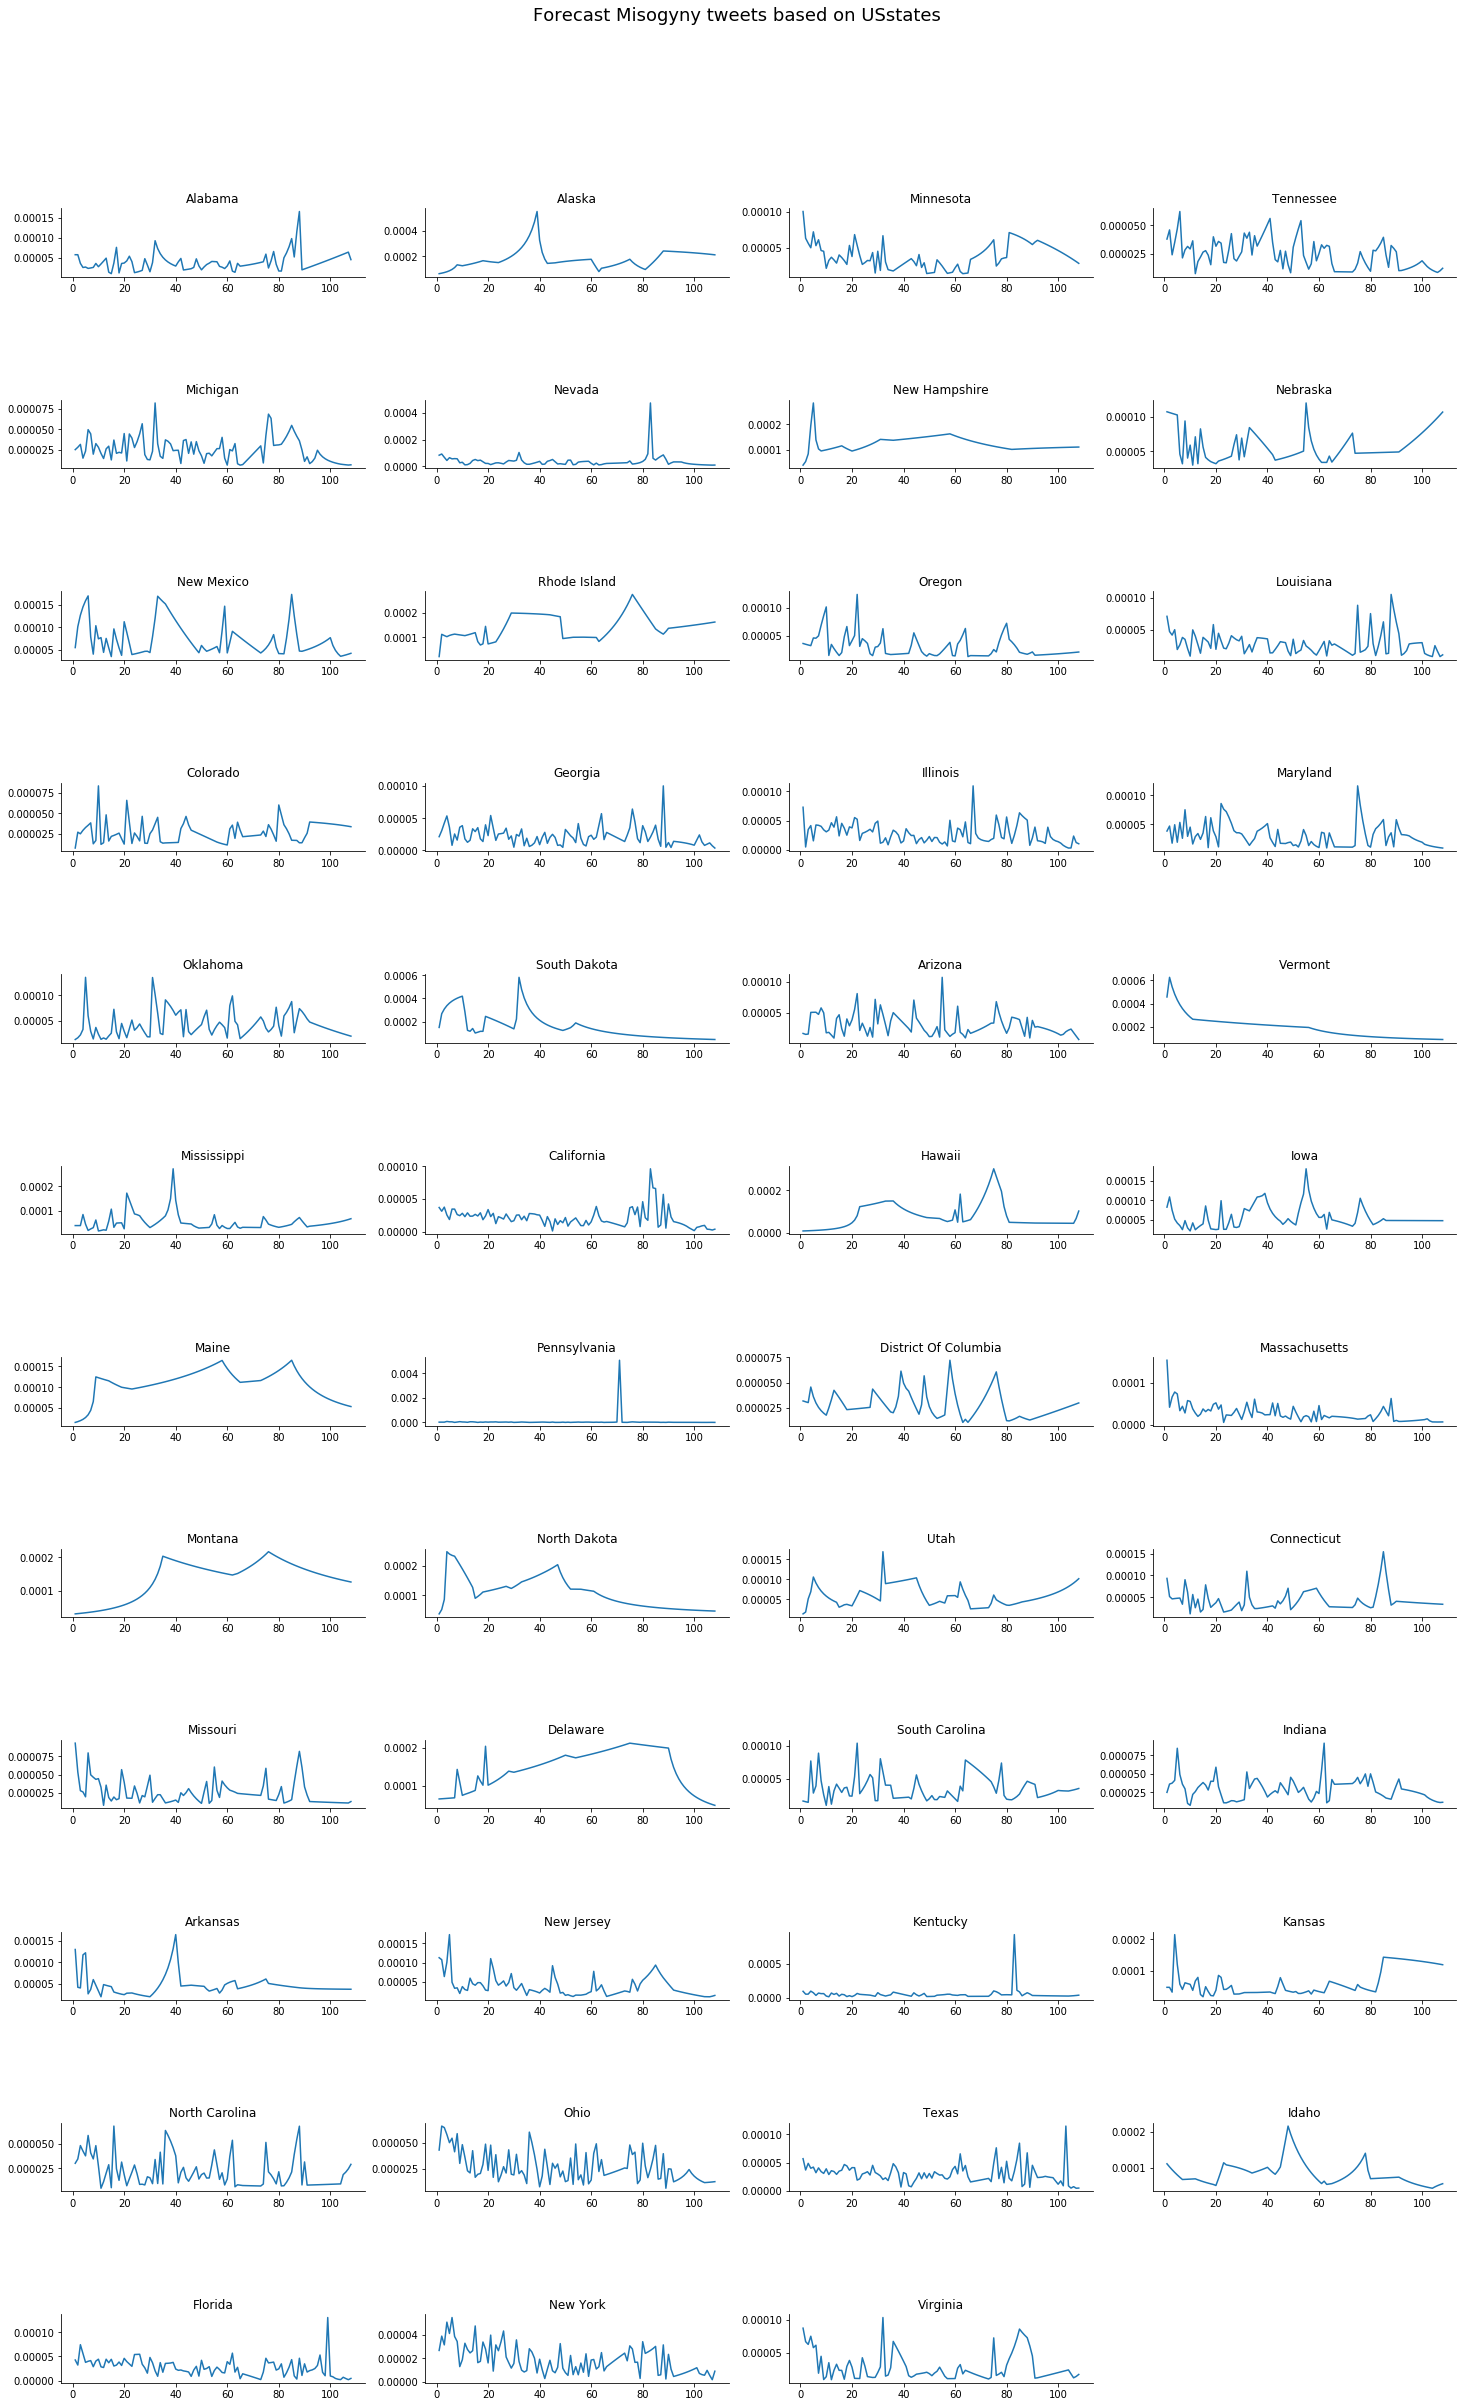

In [9]:
plt.figure(figsize=(25, 40))
plt.subplots_adjust(hspace=1.8)
plt.suptitle("Forecast Misogyny tweets based on USstates", fontsize=18, y=0.95)

for i in range(len(state_list)):
    
    data = merged_data[merged_data['USstate']==state_list[i]]
    curr_state = data['full'].iloc[0]
    data = data.groupby(['year','month']).sum()
    data['misogyny_proportion'] = data['nTweets_y'] / data['nTweets_x']
    
    x2_misogyny_proportion = data['misogyny_proportion'].to_numpy()
    

    # plot
    ax = plt.subplot(12, 4, i+1)
    ax.plot(np.arange(1,109),x2_misogyny_proportion)
    ax.set_title(curr_state)
    sns.despine()

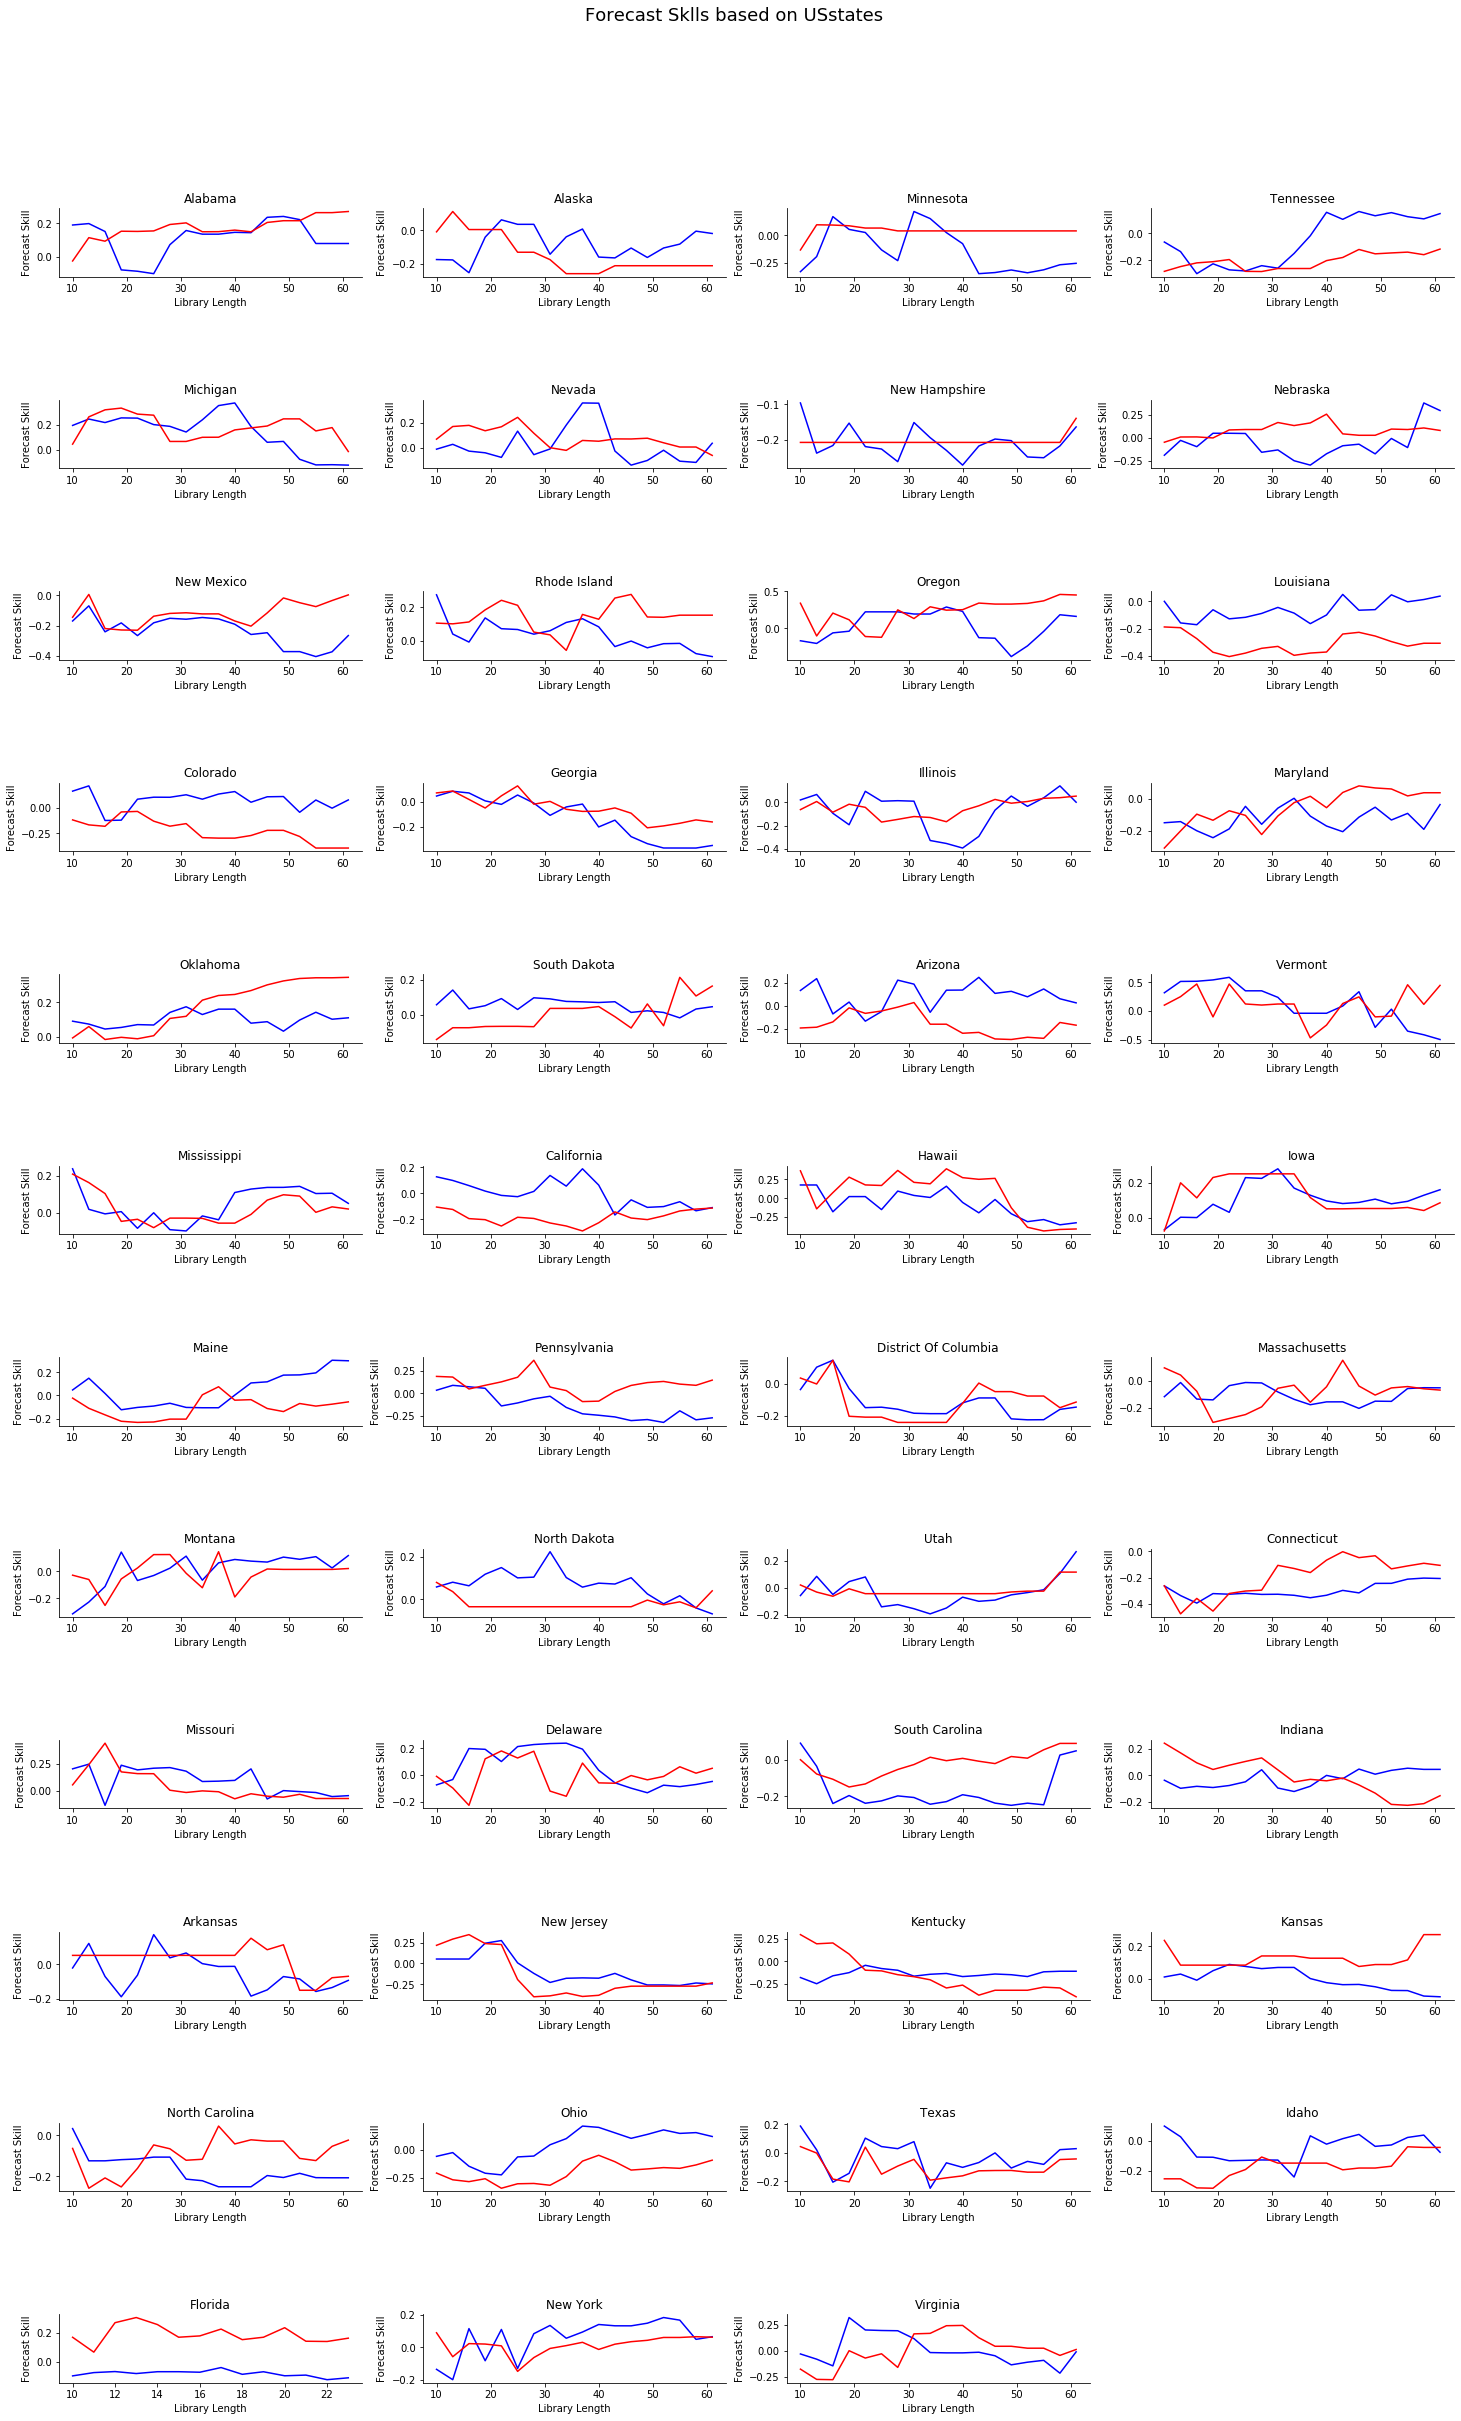

In [10]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

plt.figure(figsize=(25, 40))
plt.subplots_adjust(hspace=1.8)
plt.suptitle("Forecast Sklls based on USstates", fontsize=18, y=0.95)

for i in range(len(state_list)):
    
    data = merged_data[merged_data['USstate']==state_list[i]]
    curr_state = data['full'].iloc[0]
    data = data.groupby(['year','month']).sum()
    data['misogyny_proportion'] = data['nTweets_y'] / data['nTweets_x']
    
    # 0. extract data
    x1_misogyny_proportion = data['misogyny_proportion'].to_numpy()
    x2_rape_total = data['actual_rape_total'].to_numpy()
    
    # 1. Calculate Mutual information
    e1 = ccm.Embed(x1_misogyny_proportion)
    e2 = ccm.Embed(x2_rape_total)

    mi1 = e1.mutual_information(10)
    mi2 = e2.mutual_information(10)
               
    min_index1 = min(range(len(mi1)), key=mi1.__getitem__)
    min_index2 = min(range(len(mi2)), key=mi2.__getitem__)
    min_index1 = max(min_index1, 1)
    min_index2 = max(min_index2, 1)
    lag = max(min_index1, min_index2)
    
    # 2. Embed the time series
    perc_FNN, embed = FNN_n(x2_rape_total, lag, plotting = False)
    X1 = e1.embed_vectors_1d(lag,embed)
    X2 = e2.embed_vectors_1d(lag,embed)
    
    # 3. Forecast skill as a function of library length
    # split the embedded time series
    x1tr, x1te, x2tr, x2te = train_test_split(X1,X2, percent=.75)

    CCM = ccm.CCM() # initiate the class

    # library lengths to test
    len_tr = len(x1tr)
    lib_lens = np.arange(10, len_tr, len_tr/20, dtype='int')
    
    # test causation
    CCM.fit(x1tr,x2tr)
    x1p, x2p = CCM.predict(x1te, x2te,lib_lengths=lib_lens)
    
    sc1,sc2 = CCM.score()
    # plot
    ax = plt.subplot(12, 4, i+1)
    ax.plot(lib_lens,sc1,label='X1 xmap X2', color='blue') # misogyny_tweet predict crime
    ax.plot(lib_lens,sc2, label='X2 xmap X1', color='red') # crime predict misogyny_tweet
    ax.set_xlabel('Library Length')
    ax.set_ylabel('Forecast Skill')
    ax.set_title(curr_state)
    sns.despine()

# Part B: Country-wise

In [25]:
merged_data10 = merged_data
merged_data10['misogyny_proportion'] = merged_data10['nTweets_y'] / merged_data10['nTweets_x']
merged_data10 = merged_data10.groupby(['year','month']).sum()
merged_data10 = merged_data10.drop(columns=['nTweets_x','nTweets_y','Number of establishments (ESTAB)','population'])
merged_data10

actual_rape_total  misogyny_proportion
year month                                        
2012 1                   6010             0.003028
     2                   5516             0.003103
     3                   6430             0.003074
     4                   5980             0.003904
     5                   6251             0.003888
...                       ...                  ...
2020 8                   9574             0.001982
     9                   9099             0.002010
     10                  8618             0.002017
     11                  7700             0.002021
     12                 14360             0.002061

[108 rows x 2 columns]

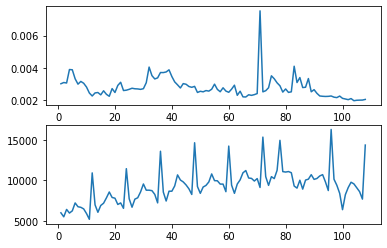

In [26]:
x1_tweet = merged_data10['misogyny_proportion'].to_numpy()
x2_crime = merged_data10['actual_rape_total'].to_numpy()

fig,ax = plt.subplots(nrows=2,sharex=False,sharey=False)
ax[0].plot(np.arange(1,109),x1_tweet)
ax[1].plot(np.arange(1,109),x2_crime)

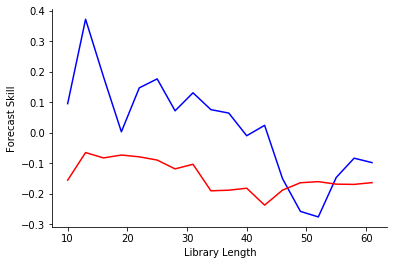

In [27]:
e1 = ccm.Embed(x1_tweet)
e2 = ccm.Embed(x2_crime)

mi1 = e1.mutual_information(10)
mi2 = e2.mutual_information(10)

min_index1 = min(range(len(mi1)), key=mi1.__getitem__)
min_index2 = min(range(len(mi2)), key=mi2.__getitem__)
min_index1 = max(min_index1, 1)
min_index2 = max(min_index2, 1)
lag = max(min_index1, min_index2)

# 2. Embed the time series
perc_FNN, embed = FNN_n(x2_crime, lag, plotting = False)
X1 = e1.embed_vectors_1d(lag,embed)
X2 = e2.embed_vectors_1d(lag,embed)

# 3. Forecast skill as a function of library length
# split the embedded time series
x1tr, x1te, x2tr, x2te = train_test_split(X1,X2, percent=.75)

CCM = ccm.CCM() # initiate the class

# library lengths to test
len_tr = len(x1tr)
lib_lens = np.arange(10, len_tr, len_tr/20, dtype='int')

# test causation
CCM.fit(x1tr,x2tr)
x1p, x2p = CCM.predict(x1te, x2te,lib_lengths=lib_lens)

sc1,sc2 = CCM.score()

fig,ax = plt.subplots()
ax.plot(lib_lens,sc1,label='X1 xmap X2', color='blue') # misogyny_tweet predict crime
ax.plot(lib_lens,sc2, label='X2 xmap X1', color='red') # crime predict misogyny_tweet
ax.set_xlabel('Library Length')
ax.set_ylabel('Forecast Skill')
sns.despine()